### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [5]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [7]:
%config Completer.use_jedi = False

### Load pre matching data

In [8]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [10]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((22364, 92), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 92), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, offset_month=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p")

In [17]:
sorted_months = treated.MYR.sort_values().unique()

In [18]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [19]:
treated_aggregate = pd.read_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p") #goes into matching as tr_agg

In [20]:
#controls_aggregate = data_process.get_average_final_record(controls2.copy(), sorted_months, pmpm[col_seq_can_all].copy())
#controls_aggregate.to_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [21]:
controls_aggregate = pd.read_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [22]:
controls_aggregate.shape, controls2.shape

In [23]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls2[controls2.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [24]:
del treated, controls, controls2

In [25]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [26]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_AE_logfixed", compile=False)

In [27]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [28]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [29]:
treated_latent = data_process.transform_features_with_NN(model, treated_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
treated_latent1 = treated_original[cols_to_keep+extra_cols]
treated_latent = pd.concat([treated_latent1, treated_latent.loc[:,'x1':]], axis=1)

In [30]:
controls_latent = data_process.transform_features_with_NN(model, controls_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
controls_latent1 = controls_original[cols_to_keep+extra_cols]
controls_latent = pd.concat([controls_latent1, controls_latent.loc[:,'x1':]], axis=1)

In [31]:
del treated_latent1, controls_latent1

In [32]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [33]:
controls_latent.shape, controls_original.shape

# Matching

In [34]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:263545 before they were:293527


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1367it [21:13,  1.07it/s]

There were no matches for 0 out of 1367 patients
CPU times: user 31min 27s, sys: 21min 39s, total: 53min 6s
Wall time: 21min 16s


In [35]:
controls = pd.read_pickle(pp_str+'controlsPast.p')

In [36]:
controls_all =  pd.DataFrame()
matched_data1 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [37]:
%%time
counter = 0

for (key, month), val in matched0.items():
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data1 = pd.concat((matched_data1, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1

CPU times: user 7min 54s, sys: 1min 32s, total: 9min 27s
Wall time: 9min 27s


In [38]:
matched_data0

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  CC_DIABETES  IP_BIN6  ER_BIN6  LOB        x1         x2        x3          x4        x5        x6        x7        x8        x9       x10       x11       x12       x13       x14         x15         x16
0      2594494  201908               83         0          0.0      0.0      0.0    1 -0.007053  12.529276 -0.012849   57.236782  0.558875 -0.515018  0.181493 -0.629840 -0.543451 -0.609452  0.825675 -0.151984  0.169542 -0.397933   57.768223   37.664669
1      2594494  201909               83         0          0.0      0.0      0.0    1 -0.052892  38.746696 -0.110232  171.670425  1.568233 -1.449800  0.568981 -1.854276 -1.589531 -2.649245  2.480666 -0.419213  1.332475 -1.211867  173.120819  113.326180
2      2594494  201910               83         0          0.0      0.0      0.0    1 -0.033819  27.867727 -0.069770  124.187477  1.149430 -1.061951  0.408188 -1.346130 -1.155421 -1.802965  1.793953 -0.308262  0.849846 -0.874093  125.256699   81.930954
3      2594494  201911               84         0          0.0      0.0      0.0    1  0.002341   7.141784  0.007146   33.720482  0.351406 -0.322872  0.101897 -0.378247 -0.328487 -0.190180  0.485533 -0.097075 -0.069432 -0.230705   34.063011   22.116198
4      2594494  201912               84         0          0.0      0.0      0.0    1  0.004910   5.687618  0.012553   27.373850  0.295411 -0.271028  0.080412 -0.310297 -0.270450 -0.077001  0.393745 -0.082234 -0.133952 -0.185525   27.665359   17.919785
...        ...     ...              ...       ...          ...      ...      ...  ...       ...        ...       ...         ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...         ...         ...
91147  5004424  202103               32         0          0.0      0.0      1.0    1  0.008737   4.826896  0.016336   23.659113  0.262008 -0.242790  0.068773 -0.267543 -0.238248 -0.009597  0.339447 -0.073420 -0.168675 -0.155172   23.907951   15.443345
91148  5004424  202104               32         0          0.0      0.0      1.0    1 -0.055618  41.639183 -0.120391  184.338089  1.679329 -1.555368  0.612839 -1.986758 -1.707071 -2.873801  2.663283 -0.448618  1.464200 -1.297984  185.877304  121.681503
91149  5004424  202105               32         0          0.0      0.0      1.0    1  0.016144   0.824409  0.030920    6.195447  0.107851 -0.100202  0.009565 -0.080220 -0.078180  0.302264  0.086903 -0.031990 -0.346186 -0.030445    6.303335    3.898684
91150  5004424  202106               32         0          0.0      0.0      1.0    1  0.014042   1.769757  0.027660   10.314407  0.144265 -0.133725  0.023615 -0.124785 -0.116267  0.228412  0.146432 -0.042276 -0.304243 -0.060271   10.455958    6.620208
91151  5004424  202107               32         0          0.0      0.0      0.0    1  0.017275   0.399070  0.032209    4.341502  0.091578 -0.085194  0.003113 -0.060196 -0.061088  0.335497  0.060234 -0.027307 -0.365143 -0.016944    4.434325    2.674982

[91152 rows x 24 columns]

In [39]:
matched_data1

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0          25944940  201908         0               83         92     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              1.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1          25944940  201909         0               83          0     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              1.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2          25944940  201910         0               83        122     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          4                    0.0          0.0              1.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3          25944940  201911     

In [40]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [41]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [42]:
data_base = "./Final/Data/AE_g/"
result_base = "./Final/results/AE_g/"
Path(data_base).mkdir(exist_ok=True)
Path(result_base).mkdir(exist_ok=True)

In [43]:
matched_controls_5N.to_pickle(data_base+"matched0.p")

In [44]:
controls_all.to_pickle(data_base+'controls_all.p')

In [45]:
matched_data0.to_pickle(data_base+"matched_controls_latent_from_algo.p")

In [46]:
matched_data1.to_pickle(data_base+"matched_controls_latent_after_process.p")

### Calculate matched controls agg and matched controls original 

In [47]:
# matched_controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(matched_data1.set_index(['PERS_ID2','MYR']).index)].reset_index(drop=True)

In [48]:
matched_controls_original = matched_data1

In [49]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [50]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [51]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [52]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [53]:
# del controls, controls2

In [54]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')

In [55]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 37s, sys: 8.01 s, total: 2min 45s
Wall time: 2min 45s


In [56]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.738113        50.767394  -0.079075  9.369748e-01          44.310976   47.606399
ALLOW_AMT        712.070227       699.856159   0.145629  8.842181e-01        1065.926022  648.802692
MBR_GNDR           0.212143         0.211953   0.015756  9.874295e-01           0.442749    0.431056
CC_TOBACCO         0.061448         0.087154  -3.148356  1.647814e-03           0.074202    0.098400
CC_PRESSURE        0.001463         0.002637  -0.802553  4.222562e-01           0.007390    0.006602
CC_OBESITY         0.498903         0.298374  14.555198  2.107414e-47           0.108841    0.228035
CC_HYPERTENSION    0.342356         0.245935   7.423907  1.251241e-13           0.207717    0.249365
CC_HYPOTHYROID     0.100951         0.086568   1.705063  8.822054e-02           0.047300    0.063484
CC_DX_CNT          2.912217         2.422294   7.505093  6.782602e-14           1.824419    2.343702
ACUTE2             0.039503         0.034862   0.808322  4.189290e-01           0.063258    0.051549
ACUTE6             0.115582         0.108247   0.638122  5.234120e-01           0.063258    0.153377
IP_BIN6            0.029993         0.026512   0.637622  5.237373e-01           0.020587    0.046851
ER_BIN6            0.091441         0.086422   0.496775  6.193608e-01           0.047286    0.116176
LOB                0.954645         0.955764  -0.183217  8.546324e-01           0.755775    0.787836

In [57]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [58]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.41 s, sys: 6.6 ms, total: 2.41 s
Wall time: 2.41 s


In [59]:
conds_lat

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1   -0.011586        -0.011095 -0.324762  0.745370          -0.011586  -0.011586
x2   16.556195        15.973804  0.663430  0.507075          16.556195  16.556195
x3   -0.025252        -0.022857 -0.764145  0.444804          -0.025252  -0.025252
x4   74.855548        72.308259  0.664696  0.506264          74.855548  74.855548
x5    0.710074         0.686612  0.699975  0.483964           0.710074   0.710074
x6   -0.658276        -0.636157 -0.709976  0.477740          -0.658276  -0.658276
x7    0.248304         0.241138  0.530745  0.595611           0.248304   0.248304
x8   -0.812264        -0.784694 -0.676213  0.498925          -0.812264  -0.812264
x9   -0.706175        -0.682437 -0.675603  0.499313          -0.706175  -0.706175
x10  -0.916352        -0.869547 -0.688679  0.491046          -0.916352  -0.916352
x11   1.077299         1.039942  0.675951  0.499092           1.077299   1.077299
x12  -0.189879        -0.183080 -0.771358  0.440518          -0.189879  -0.189879
x13   0.354408         0.328327  0.661644  0.508219           0.354408   0.354408
x14  -0.518000        -0.500065 -0.663076  0.507301          -0.518000  -0.518000
x15  75.499816        72.931278  0.665174  0.505959          75.499816  75.499816
x16  49.284453        47.601450  0.664597  0.506328          49.284453  49.284453

In [60]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [61]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 3.13 s, sys: 10.5 ms, total: 3.14 s
Wall time: 3.14 s


In [62]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                    mean             mean  t-stat   pval
AGE_AT_MIDMONTH   50.261           50.308  -0.126  0.900
ALLOW_AMT        828.277          729.657   1.912  0.056
MBR_GNDR           0.212            0.218  -0.497  0.619
CC_TOBACCO         0.055            0.084  -3.865  0.000
CC_PRESSURE        0.001            0.002  -0.541  0.589
CC_OBESITY         0.442            0.272  13.547  0.000
CC_HYPERTENSION    0.320            0.236   7.118  0.000
CC_HYPOTHYROID     0.090            0.081   1.185  0.236
CC_DX_CNT          2.649            2.295   5.680  0.000
LOB                0.954            0.951   0.527  0.598

In [63]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [64]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 30.8 s, sys: 2.43 s, total: 33.2 s
Wall time: 33.2 s


In [65]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           51.388  -3.401  0.001             50.379   50.236
ALLOW_AMT        812.538          781.228   0.793  0.428            857.856  706.609
MBR_GNDR           0.196            0.198  -0.676  0.499              0.433    0.429
CC_TOBACCO         0.064            0.092 -13.300  0.000              0.102    0.100
CC_PRESSURE        0.003            0.003  -0.742  0.458              0.013    0.008
CC_OBESITY         0.533            0.337  55.597  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.261  21.541  0.000              0.329    0.300
CC_HYPOTHYROID     0.098            0.089   4.033  0.000              0.078    0.075
CC_DX_CNT          3.049            2.647  23.959  0.000              2.955    2.759
ACUTE2             0.032            0.036  -2.506  0.012              0.060    0.050
ACUTE6             0.101            0.108  -2.706  0.007              0.168    0.150
IP_BIN6            0.026            0.031  -3.148  0.002              0.055    0.049
ER_BIN6            0.079            0.083  -1.712  0.087              0.122    0.111
LOB                0.955            0.952   1.683  0.092              0.802    0.803

In [66]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [67]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 159 ms


In [68]:
conds_latA

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1   -0.011827        -0.012733  1.988411  0.046769          -0.011827  -0.011827
x2   16.647129        17.361921 -2.735166  0.006236          16.647129  16.647129
x3   -0.025605        -0.027791  2.326921  0.019971          -0.025605  -0.025605
x4   75.253014        78.399506 -2.758034  0.005816          75.253014  75.253014
x5    0.713524         0.739462 -2.597001  0.009405           0.713524   0.713524
x6   -0.661415        -0.685419  2.587924  0.009657          -0.661415  -0.661415
x7    0.249684         0.265652 -4.005443  0.000062           0.249684   0.249684
x8   -0.816500        -0.843739  2.239582  0.025120          -0.816500  -0.816500
x9   -0.709729        -0.734759  2.392928  0.016716          -0.709729  -0.709729
x10  -0.923487        -0.968427  2.216846  0.026636          -0.923487  -0.923487
x11   1.083030         1.123100 -2.432434  0.014999           1.083030   1.083030
x12  -0.190755        -0.192078  0.499771  0.617237          -0.190755  -0.190755
x13   0.358380         0.383989 -2.185501  0.028854           0.358380   0.358380
x14  -0.520809        -0.543373  2.800369  0.005105          -0.520809  -0.520809
x15  75.900703        79.066528 -2.753723  0.005893          75.900703  75.900703
x16  49.547085        51.621758 -2.751667  0.005930          49.547085  49.547085

In [69]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [70]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 628 ms, sys: 0 ns, total: 628 ms
Wall time: 627 ms


In [71]:
conds_aggA

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.584865        51.022435  -4.742638  2.112085e-06          50.260886   50.260886
ALLOW_AMT        830.112429       798.671996   2.059113  3.948572e-02         828.276976  828.276976
MBR_GNDR           0.196074         0.203542  -2.492233  1.269568e-02           0.212143    0.212143
CC_TOBACCO         0.062775         0.091118 -14.288018  2.851120e-46           0.054730    0.054730
CC_PRESSURE        0.001861         0.002775  -2.563819  1.035403e-02           0.001407    0.001407
CC_OBESITY         0.512188         0.331432  54.370679  0.000000e+00           0.442005    0.442005
CC_HYPERTENSION    0.327053         0.262980  20.958315  2.411968e-97           0.320176    0.320176
CC_HYPOTHYROID     0.093022         0.089523   1.781322  7.486261e-02           0.089568    0.089568
CC_DX_CNT          2.891615         2.614829  17.235290  1.754577e-66           2.648890    2.648890
LOB                0.956211         0.952479   2.402863  1.626886e-02           0.954162    0.954162

In [72]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [73]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [74]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [75]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [76]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [77]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [78]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [79]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [80]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [81]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [82]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [83]:
controls_original.shape, matched_controls_original.shape

In [84]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [85]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [86]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [87]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [88]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [89]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.661907  2.757797   2.663444
ALLOW_AMT        0.149042  0.188666   0.146486
MBR_GNDR         0.428267  0.876618   0.427882
CC_TOBACCO       0.198635  0.347112   0.281729
CC_PRESSURE      0.011972  0.124699   0.021575
CC_OBESITY       1.084936  0.659670   0.648858
CC_HYPERTENSION  0.707053  0.775361   0.507920
CC_HYPOTHYROID   0.353205  0.313860   0.302882
CC_DX_CNT        0.963439  1.112345   0.801360
ACUTE2           0.157228  0.226504   0.138756
ACUTE6           0.222796  0.333188   0.208657
IP_BIN6          0.101681  0.201059   0.089882
ER_BIN6          0.214092  0.289287   0.202339
LOB              2.493946  2.144663   2.496868

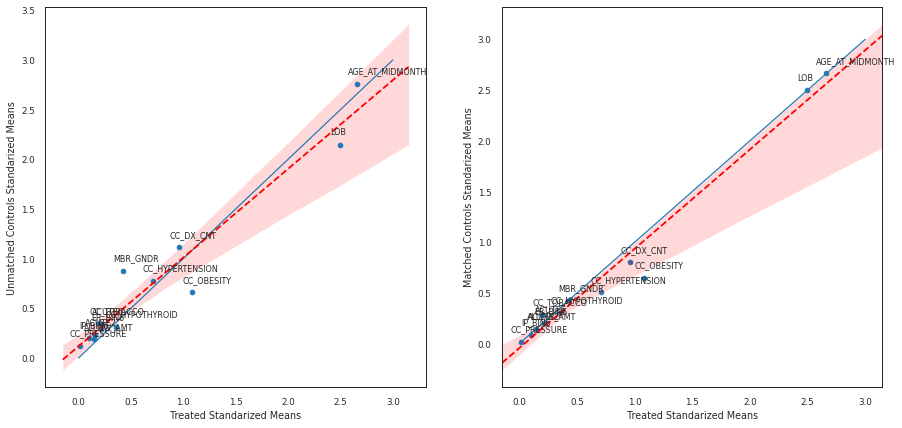

In [90]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [91]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [92]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [93]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [94]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [95]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE    IP_C    ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  HasPast  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424    0.03231  0.069515  0.064048  0.086992  0.0769  0.0074  0.017141  0.137075  0.112263  0.154748  0.092436  0.081752  0.111771  0.23801

In [96]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [97]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

62

In [98]:
d1 = d_metric_before.loc[:,:'LOB']

In [99]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424

In [100]:
d1.T[d1.T[0]<0.1].size

53

In [101]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [102]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [103]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

79

In [104]:
d2 = d_metric_after.loc[:,:'LOB']

In [105]:
d2.T[d2.T[0]<0.1].size

66

In [106]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.009426         0.271242   0.320508  0.262652  0.151349  2.326228      0.439516           0.462541  0.214706   0.262079              0.17833      3.766868   0.792395       0.074564    0.52545     0.03591  0.155832          0.552285     0.374443           0.745137           0.061925               0.38775  0.063302            0.966757       0.695879                 0.364663           0.471205     0.380628         0.290672   1.512883               1.326956     0.496759        10.611856     0.176351            0.07092          0.246063             NaN             16.196505                 0.95607                   NaN                 0.08432                    0.091538             NaN             NaN          0.016366         0.552371           0.722278         1.722081        1.043006      0.720376     0.071255        0.597522      2.823527  0.688862        0.383637      0.34988            0.078773               0.167189               0.850176    0.843349          0.72468   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY   IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2   HasPast  
0       0.010948        1.575422     0.041733            0.013786  0.542361          0.636787                0.701668        0.779105         2.981993    0.33275    0.665432            1.519517          0.327727  0.028793   0.727362  0.19946  0.189084  0.180475  0.231422  1.491342  1.003371  0.176643  0.108136  0.126856  0.208816  0.162109  0.167628  0.801709

In [107]:
ratio.T[ratio.T[0]>=1.0].size

14

In [108]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [109]:
!aws s3 cp ./Final/Data/AE_g s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g --recursive --acl bucket-owner-full-control

upload: Final/Data/AE_g/matched0.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched0.p
upload: Final/Data/AE_g/matched_controls_latent_from_algo.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_latent_from_algo.p
upload: Final/Data/AE_g/matched_controls_original.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_original.p
upload: Final/Data/AE_g/matched_controls_aggregate.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_aggregate.p
upload: Final/Data/AE_g/matched_controls_latent_after_process.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/matched_controls_latent_after_process.p
upload: Final/Data/AE_g/controls_all.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_g/controls_all.p
